In [19]:
import copy, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
train = pd.read_csv('train.csv').dropna()

In [21]:
train_close = train['close'].values

In [22]:
features = train.drop(['date', 'symbols', 'close'], axis=1)

In [23]:
correlations = features.corrwith(train['close']).sort_values(ascending=False)
print("\nFeature correlations with 'close':\n", correlations)


Feature correlations with 'close':
 open                 0.815747
high                 0.790548
liquidity_ratio      0.762245
low                  0.756308
beta_indicator       0.736197
oscillator_value     0.685826
risk_premium         0.578286
market_sentiment     0.501344
alpha_signal         0.382387
technical_score      0.347442
volatility_factor    0.309150
trend_strength       0.289055
momentum_index       0.266876
quant_index          0.062934
index                0.002384
volume              -0.130597
dtype: float64


We will choose the top 6 features from the above. 

In [24]:
top_n = 6
top_features = correlations.head(top_n).index.tolist()
print(f"\nTop {top_n} correlated features: {top_features}")


Top 6 correlated features: ['open', 'high', 'liquidity_ratio', 'low', 'beta_indicator', 'oscillator_value']


In [25]:
features = features[top_features]

In [26]:
print(top_features)

['open', 'high', 'liquidity_ratio', 'low', 'beta_indicator', 'oscillator_value']


For Normalization :

In [27]:
means = np.mean(features, axis=0)
stds = np.std(features, axis=0)
stds = np.where(stds == 0, 1e-8, stds)

features_norm = (features - means) / stds

target_mean = np.mean(train_close)
target_std = np.std(train_close)
y = (train_close - target_mean) / target_std

Creating the column of 1's (intercepts for the linear regression equation) : 

In [28]:
m, n = features_norm.shape
X = np.c_[np.ones(m), features_norm.values]

defining the necessary functions : 

In [51]:
def compute_cost(X, y, w):
    m = len(y)
    return np.sum((X @ w - y)**2) / (2*m)

def compute_gradient(X, y, w):
    m = len(y)
    return (X.T @ (X @ w - y)) / m

def gradient_descent(X, y, w_in, alpha, num_iters):
    J_history = []
    rmse = []
    w = copy.deepcopy(w_in)
    for i in range(num_iters):
        grad = compute_gradient(X, y, w)
        w -= alpha * grad
        J_history.append(compute_cost(X, y, w))
        rmse.append(np.sqrt(2 * compute_cost(X, y ,w)))
        if i % max(1, num_iters//10) == 0:
            print(f"Iter {i:4d}: Cost = {J_history[-1]:.6f}")
    return w, J_history, rmse

now, training the model : 

In [52]:
np.random.seed(42)
w_init = np.random.randn(X.shape[1]) * 0.01
alpha = 0.001
iters = 6000

print("\nTraining on top correlated features only...")
w_final, J_hist, rmse = gradient_descent(X, y, w_init, alpha, iters)

print("\nFinal weights:\n", dict(zip(['bias'] + top_features, w_final)))
print("Final cost:", J_hist[-1])


Training on top correlated features only...
Iter    0: Cost = 0.474192
Iter  600: Cost = 0.058930
Iter 1200: Cost = 0.054652
Iter 1800: Cost = 0.054384
Iter 2400: Cost = 0.054246
Iter 3000: Cost = 0.054163
Iter 3600: Cost = 0.054113
Iter 4200: Cost = 0.054082
Iter 4800: Cost = 0.054064
Iter 5400: Cost = 0.054052

Final weights:
 {'bias': np.float64(1.2275406721565285e-05), 'open': np.float64(0.25126679766053484), 'high': np.float64(0.2222400925386991), 'liquidity_ratio': np.float64(0.1933215395092843), 'low': np.float64(0.18774725176114038), 'beta_indicator': np.float64(0.17105141201012192), 'oscillator_value': np.float64(0.1396325366226431)}
Final cost: 0.054044775217588784


results for the training : 

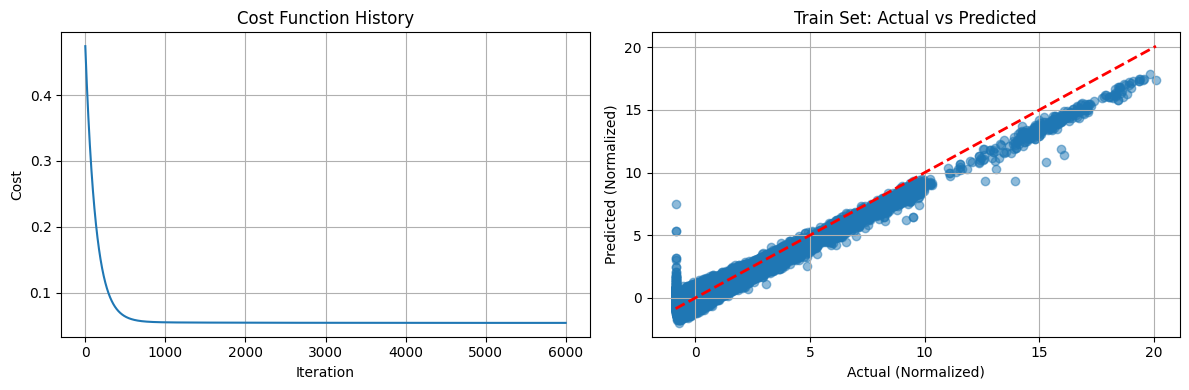

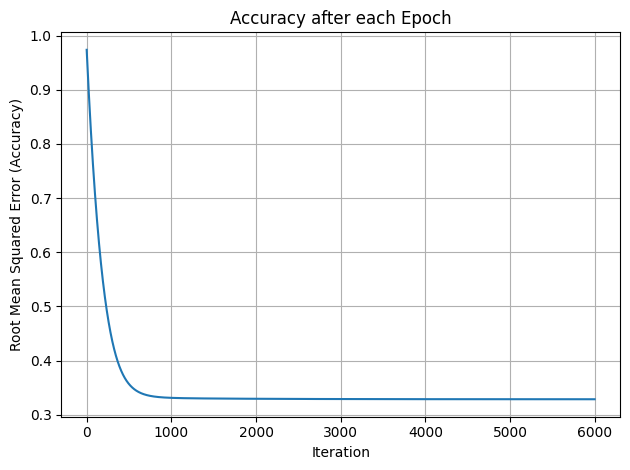

In [53]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(J_hist)
plt.title('Cost Function History')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(True)

plt.subplot(1,2,2)
pred_train = X @ w_final
plt.scatter(y, pred_train, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Train Set: Actual vs Predicted')
plt.xlabel('Actual (Normalized)')
plt.ylabel('Predicted (Normalized)')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.plot(rmse)
plt.title('Accuracy after each Epoch')
plt.xlabel('Iteration')
plt.ylabel('Root Mean Squared Error (Accuracy)')
plt.grid(True)
plt.tight_layout()
plt.show()



test final weights/parameters on the test data

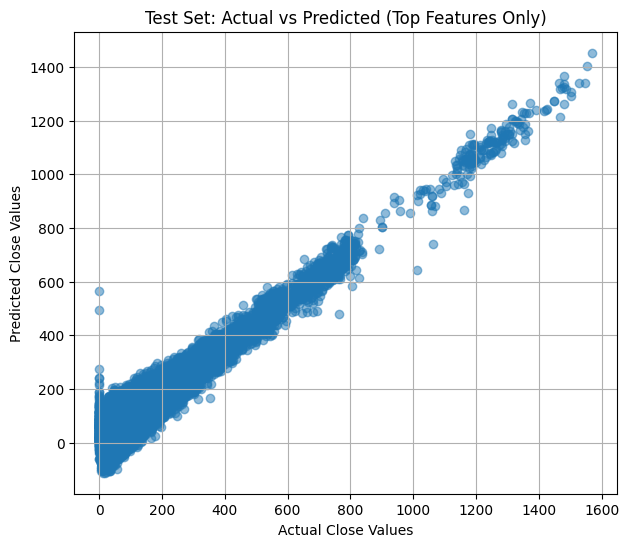


Sample predictions (real):
Predicted: 52.34, Actual: 42.10
Predicted: 82.36, Actual: 102.64
Predicted: 87.59, Actual: 46.15
Predicted: 77.50, Actual: 51.86
Predicted: 45.89, Actual: 40.79


In [54]:
Xt = pd.read_csv('test.csv')
Yt = Xt['close'].values
Xt_features = Xt[top_features]

Xt_norm = (Xt_features - means) / stds
Xt_norm = np.c_[np.ones(len(Xt_norm)), Xt_norm.values]

pred_norm = Xt_norm @ w_final
pred_real = pred_norm * target_std + target_mean


plt.figure(figsize=(7,6))
plt.scatter(Yt, pred_real, alpha=0.5)
plt.xlabel('Actual Close Values')
plt.ylabel('Predicted Close Values')
plt.title('Test Set: Actual vs Predicted (Top Features Only)')
plt.grid(True)
plt.show()

print("\nSample predictions (real):")
for i in range(5):
    print(f"Predicted: {pred_real[i]:.2f}, Actual: {Yt[i]:.2f}")
